In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import plotting as pl

### Read in the data

In [2]:
data = pd.read_csv('data/higgs_data.csv')

higgs_85 = pd.read_csv('data/higgs_higgs_85.csv')
higgs_90 = pd.read_csv('data/higgs_higgs_90.csv')
higgs_95 = pd.read_csv('data/higgs_higgs_95.csv')
eeqq = pd.read_csv('data/higgs_eeqq.csv')
qq = pd.read_csv('data/higgs_qq.csv')
wen = pd.read_csv('data/higgs_wen.csv')
ww = pd.read_csv('data/higgs_ww.csv')
zee = pd.read_csv('data/higgs_zee.csv')
zz = pd.read_csv('data/higgs_zz.csv')


framesMC_NoHiggs = [qq, ww, zz, zee, wen, eeqq]
framesMC_NoHiggsNames = ['qq', 'ww', 'zz', 'zee', 'wen', 'eeqq']

framesMC_HiggsModels = [higgs_85, higgs_90, higgs_95]
framesMC_HiggsModelsNames = ['higgs_85', 'higgs_90', 'higgs_95']



#framesListMc = framesMcNoHiggs + [higgs_85, higgs_90, higgs_95]
#framesListMcNames = framesMcNoHiggsNames + ['higgs_85', 'higgs_90', 'higgs_95']


"""
# mvisf values are to high for histograms- lower by 10e15
for frame in framesListMc:
    frame['mvisf']/= 10e15
data['mvisf']/= 10e15
"""

"\n# mvisf values are to high for histograms- lower by 10e15\nfor frame in framesListMc:\n    frame['mvisf']/= 10e15\ndata['mvisf']/= 10e15\n"

<img src="samples_full.png"> 

### Introduce weights in order to rescale all the MC samples to the same luminosity

per definition the weight of each measured event (data) is $1$. Thus, we want to rescale the MC to the same ntegrated Luminosity of the data taking which is $L = 176.773 \ \mathrm{pb}^{-1}$

The weight for each MC sample is:
$$ 
        \mathrm{weight}_\mathrm{MC} = L \cdot  \frac{\sigma_\mathrm{MC} }{N_\mathrm{MC}}
$$

In [3]:
# load classifier
import cPickle
from sklearn.tree import DecisionTreeClassifier

with open('GBCL.pkl', 'rb') as fid:
    gnb_loaded = cPickle.load(fid)
with open('SVM_PreProcessed_balanced.pkl', 'rb') as fid:
    SVM_loaded = cPickle.load(fid)

In [4]:
def PickDiscVar_mH85 (df) :
    discriminating_vars = ['btag1','btag2','ucsdbt0','acthm','mvissc','mmis']+['class','weight']
    discriminating_vars = ['ucsdbt0','acthm','mvissc','mmis','xmj1','acop']+['class','weight']
    discriminating_vars = [u'btag1', u'btag2',
       u'ucsdbt0', u'mvis', u'mvissc', u'fmvis', u'fmmis', u'fth1',
       u'mmis', u'acthm', u'maxcthj', u'acop', u'maxxov', u'enj1',
       u'thj1', u'phj1', u'xmj1', u'enj2', u'thj2', u'phj2', u'xmj2',
       u'pho_num', u'pho_ene', u'pho_the', u'pho_phi', u'ele_num', u'ele_ene',
       u'ele_the', u'ele_phi', u'muon_num', u'muon_ene', u'muon_the',
       u'muon_phi']
    return df[discriminating_vars]

In [5]:
def Scale (df) :
    min_on_training = np.array([  0., 0.,      0.,     40.469,  50.749,  46.922,  91.013,   0.137,  50.,      0.,
   0.002,   0.003,   0.041,  28.927,   0.246,   0.,      2.04,    8.356,   0.016,
   0.,      2.004,   0.,     -1.,      0.,      0.,      0.,     -1.,      0.,      0.,
   0.,     -1.,      0. ,     0.   ])
    range_on_training = [  1.,      1.,     16.493,  97.858,  47.048,  50.98,    0.698,   2.953,  79.988,
   0.96,    0.998,   3.138,   0.839,  66.076,   2.65,    6.283 , 67.932,  60.739,
   3.119,   6.283 , 54.567 ,  6. ,    62.469 ,  2.953,   6.284 ,  4.,     67.375,
   2.888,   6.283 ,  3.   ,  70.25 ,   2.749,   6.283]
    return  (df - min_on_training) / range_on_training

In [6]:
crossSectionsMC_noHiggs = [102., 16.5, 0.975, 3.35, 2.9, 15600.]
NumberMC_noHiggs = [200000., 294500., 196000., 29500., 81786., 5940000.]

crossSectionsMC_HiggsModels = [0.094, 0.0667, 0.0333]
NumberMC_HiggsModels = [3972., 3973., 3971.]


Lum = 176.773


weightsMC_noHiggs     = Lum*np.array(crossSectionsMC_noHiggs) / np.array(NumberMC_noHiggs) 
weightsMC_HiggsModels = Lum*np.array(crossSectionsMC_HiggsModels) / np.array(NumberMC_HiggsModels) 


#add column 'weight' to data frame of all bkg MC
for i, frame in enumerate(framesMC_NoHiggs):
    frame["weight"] = weightsMC_noHiggs[i]
    frame['BDT_selCut'] = gnb_loaded.decision_function(PickDiscVar_mH85(df=frame))
    frame['SVM'] = SVM_loaded.decision_function(Scale(df=PickDiscVar_mH85(df=frame)))
#add column 'weight' to data frame of all bkg+sig MC
for i, frame in enumerate(framesMC_HiggsModels):
    frame["weight"] = weightsMC_HiggsModels[i]
    frame['BDT_selCut'] = gnb_loaded.decision_function(PickDiscVar_mH85(df=frame))
    frame['SVM'] = SVM_loaded.decision_function(Scale(df=PickDiscVar_mH85(df=frame)))

#add column 'weight'=1 to data 
data["weight"] = 1
data['BDT_selCut'] = gnb_loaded.decision_function(PickDiscVar_mH85(df=data))
data['SVM'] = SVM_loaded.decision_function(Scale(df=PickDiscVar_mH85(df=data)))

print len(data['weight'])


641


In [40]:
cut = -500# -3.4#1.41379310345
cut_SVC = 1.

In [41]:
print len(data[data['SVM']>cut_SVC]['weight'])
print max(data['SVM'])

34
2.99177799959


### distribution of variable of interest

In [42]:
def GetHistogram (df, column, binning) :
  
    return np.histogram(a=df[column],
                        bins = binning,
                        weights=df['weight'])[0]

In [43]:
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

In [44]:
"""
variable_dict = {variable: 'mmis', 
                           'acop',
                           'acthm',
                           'fmvis',
                             'mvis'
    
                }
x_name_dict = { x_name: r'missing mass $m_\mathrm{mis}$',  
                        r'$\pi -$ angles btw jets',
                        r'$|\cos(\phi_\mathrm{polar,pmiss})|$',
                        r'visible mass (Z-adjusted) $m_\mathrm{vis}$',
               r'visible mass $m_\mathrm{vis}$'
    
}

x_unit_dict = { x_unit: r'$\mathrm{GeV} / \mathrm{c}^2$',
                        r'$\mathrm{rad}$',
                        r'$1$',
                        r'GeV',
               r'GeV'
    
}
binning_dict = { binning: np.linspace(50.,130.,20),
                          np.linspace(1.5,np.pi,30),
                          np.linspace(0,1.,20),
                          np.linspace(60,100,20),
                          np.linspace(70,100,12)
               }
"""
mmis =  {'x_name':  r'missing mass $m_\mathrm{mis}$',
        'x_unit': r'$\mathrm{GeV} / \mathrm{c}^2$',
        'binning': np.linspace(50.,130.,5)#np.linspace(50.,130.,20)
        }
acop =  {'x_name':  r'$\pi -$ angles btw jets',
        'x_unit':  r'$\mathrm{rad}$',
        'binning': np.linspace(1.5,np.pi,30)
        }
acthm =  {'x_name':  r'$|\cos(\phi_\mathrm{polar,pmiss})|$',
        'x_unit':  r'$1$',
        'binning': np.linspace(0,1.,20),
        }
fmvis = {'x_name': r'visible mass (Z-adjusted) $m_\mathrm{vis}$',
        'x_unit':  r'GeV',
        'binning': np.linspace(60,100,20),
        }
mvis = {'x_name': r'visible mass $m_\mathrm{vis}$',
        'x_unit':  r'GeV',
        'binning': np.linspace(40,100,5)#np.linspace(40,100,20)
        }
# 0.592373282804, 0.336096938776, 0.085706920995
xmj1 = {'x_name': r'more energetic 2-jet event mass $m_\mathrm{jet1}$',
        'x_unit':  r'GeV',
        'binning': np.linspace(5,20,12)
        }
xmj2 = {'x_name': r'less energetic 2-jet event mass $m_\mathrm{jet1}$',
        'x_unit':  r'GeV',
        'binning': np.linspace(5,20,5)
        }
ucsdbt0 = {'x_name': r'B tag, based on tracking information only',
        'x_unit':  r'$1$',
        'binning': np.append(np.linspace(0,8,10),np.array([10,14]))
        }
#CL: 0.213159843436, 0.213346591537, 0.115559705848


var_dict = {'mmis': mmis,
           'acop': acop,
            'acthm': acthm,
            'fmvis': fmvis,
            'mvis': mvis,
            'xmj1': xmj1,
            'xmj2': xmj2,
            'ucsdbt0': ucsdbt0 # 
           }

#var_dict[var]['x_name']

In [45]:
path = '/home/janik/StatMethods/Project/plots/VariableDists/'
ensure_dir(file_path=path)
variable = 'mmis'
x_name = variable
x_unit = 'GeV'
binning = np.array([50,80,85,90,95,100,105,110,140])
save_path = path+variable

In [46]:
def SelectionCut (dataframe) :
    dataframe = dataframe[dataframe['btag1']>0.4]
    dataframe = dataframe[dataframe['btag2']>0.4]
    
    return dataframe

In [47]:
"""bkg = np.zeros(len(binning)-1)
for dataframe in framesMC_NoHiggs :
    # do selection cuts    
    bkg += GetHistogram(df=SelectionCut(dataframe=dataframe),column=variable,binning=binning)

    
    
sigModels = [] 
for dataframe in framesMC_HiggsModels :
    
    sigModels.append(GetHistogram(df=SelectionCut(dataframe=dataframe),column=variable,binning=binning))
    

data_hist = GetHistogram(df=SelectionCut(dataframe=data),column=variable,binning=binning)"""

'bkg = np.zeros(len(binning)-1)\nfor dataframe in framesMC_NoHiggs :\n    # do selection cuts    \n    bkg += GetHistogram(df=SelectionCut(dataframe=dataframe),column=variable,binning=binning)\n\n    \n    \nsigModels = [] \nfor dataframe in framesMC_HiggsModels :\n    \n    sigModels.append(GetHistogram(df=SelectionCut(dataframe=dataframe),column=variable,binning=binning))\n    \n\ndata_hist = GetHistogram(df=SelectionCut(dataframe=data),column=variable,binning=binning)'

In [48]:
bkg = np.zeros(len(binning)-1)
for dataframe in framesMC_NoHiggs :
    # do selection cuts    
    #bkg += GetHistogram(df=dataframe[dataframe['BDT_selCut']>cut],column=variable,binning=binning)
    bkg += GetHistogram(df=dataframe[dataframe['SVM']>cut_SVC],column=variable,binning=binning)

    
sigModels = [] 
for dataframe in framesMC_HiggsModels :
    
    sigModels.append(GetHistogram(df=dataframe[dataframe['SVM']>cut_SVC],column=variable,binning=binning))
    

data_hist = GetHistogram(df=data[data['SVM']>cut_SVC],column=variable,binning=binning)

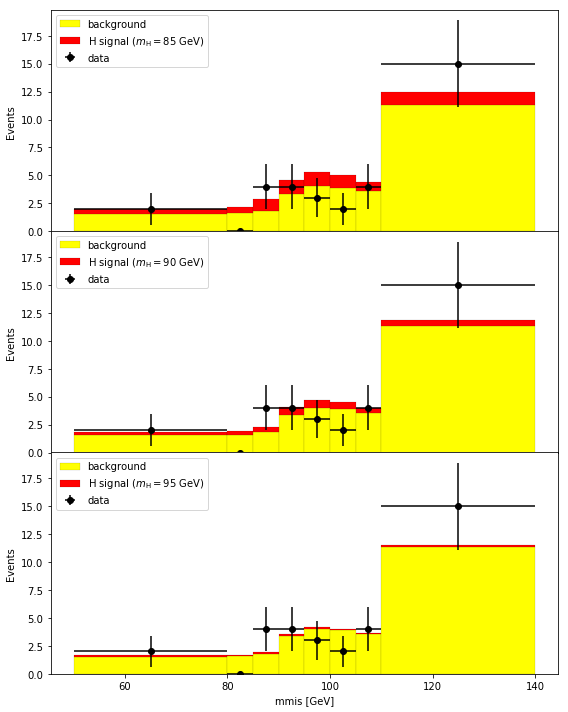

In [49]:
reload(pl)
pl.BkgSigHistos(background=bkg,signals=sigModels,data=data_hist,variable_binning=binning,
                x_label=[x_name,x_unit],savepath=None)#save_path)

## The Log-likelihood ratio we define to be

$$
    -2 \log (Q(m_H)) = 2 s_{tot} - 2 \sum_{i=1}^{N_{bins}} N_i \log \left( 1 + \frac{s_i(m_H)}{b_i} \right)
$$

In [50]:
import stats as stat
reload(stat)

<module 'stats' from 'stats.pyc'>

In [51]:
Nexp = 10000
llr_85 = stat.LogLikRatio(background=bkg,signal=sigModels[0],N_experiments=Nexp)
llr_90 = stat.LogLikRatio(background=bkg,signal=sigModels[1],N_experiments=Nexp)
llr_95 = stat.LogLikRatio(background=bkg,signal=sigModels[2],N_experiments=Nexp)

llr_obs = stat.LogLikRatioObserved(background=bkg,signals=sigModels,data=data_hist)

In [52]:
#print llr_obs
#plt.hist(llr_85, bins=30)
#plt.show()

In [53]:
path = '/home/janik/StatMethods/Project/plots/loglikeliratio/'
ensure_dir(file_path=path)
save_path = path+variable

In [54]:
print llr_obs

[0.96023915194000153, 0.12648033985529405, -0.16496995252861346]


190
161
162


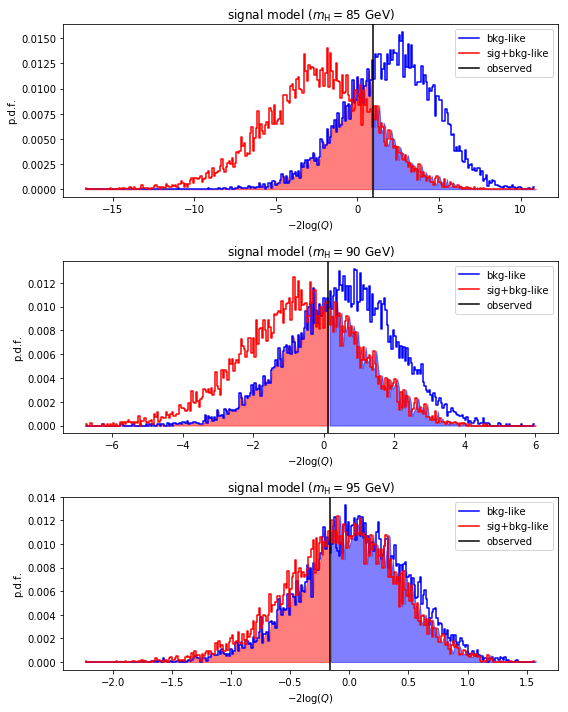

[[0.31629999999999991, 0.16330000000000006], [0.36769999999999997, 0.33460000000000001], [0.30359999999999998, 0.61199999999999966]]


In [55]:
reload(pl)
CLlist = pl.LogLikRatioPlots([llr_85,llr_90,llr_95],Nbins=300,obs=llr_obs,savepath=None)#save_path)
print CLlist

$$CL_s = \frac{CL_{s+b}}{CL_b} = \frac{CL_{s+b}}{1-(1-CL_b)}$$

In [56]:
CLs = [entry[1]/(1-entry[0]) for entry in CLlist]
print CLs

print "Confidence level CL >= "
for i in xrange(len(CLs)):
    print "    ", 1 - CLs[i]

[0.2388474477109844, 0.52917918709473344, 0.87880528431935623]
Confidence level CL >= 
     0.761152552289
     0.470820812905
     0.121194715681


## stuff to try

In [ ]:
b = bkg
s = sigModels[0]
s_tot = s.sum()

llr_b_like = []
llr_sPlusb_like = []
N_exp = 10000

for k in xrange(N_exp) :
    N = np.random.poisson(lam=b)
    llr_b_like.append(2*s_tot - 2*np.dot(N,np.log(1+s/b)))

for k in xrange(N_exp) :
    N = np.random.poisson(lam=(s+b))
    llr_sPlusb_like.append(2*s_tot - 2*np.dot(N,np.log(1+s/b)))
    
    


In [ ]:
plt.hist(llr_b_like,40,color='blue',alpha=0.5,label='bkg-like',normed=True)
plt.hist(llr_sPlusb_like,40,color='red',alpha=0.5,label='sig+bkg-like',normed=True)
plt.xlabel(r'$-2 \log (Q)$')
plt.ylabel('p.d.f.')
plt.legend()
plt.show()


In [276]:
var1 = 'mvis'
var2 = 'btag1'

def GetHistogram_TwoD (df, column1, binning1, column2, binning2) :
  
    return np.histogram2d(df[column1],
                        df[column2],
                        bins = [binning1,binning2],
                        weights=df['weight'],
                         normed=True)[0]

bkg = np.zeros((len(var_dict[var1]['binning'])-1, len(var_dict[var2]['binning'])-1))
for dataframe in framesMC_NoHiggs :
    bkg += GetHistogram_TwoD(df=dataframe,
                             column1=var1,binning1=var_dict[var1]['binning'],
                             column2=var2,binning2=var_dict[var2]['binning'])

sigModels = [] 
for dataframe in framesMC_HiggsModels :
    sigModels.append(GetHistogram_TwoD(df=dataframe,
                             column1=var1,binning1=var_dict[var1]['binning'],
                             column2=var2,binning2=var_dict[var2]['binning']))
    

data_hist = GetHistogram_TwoD(df=data,
                             column1=var1,binning1=var_dict[var1]['binning'],
                             column2=var2,binning2=var_dict[var2]['binning'])

for dataframe in framesMC_HiggsModels :
    plt.hist2d(dataframe[var1],
                        dataframe[var2],
                        bins = [var_dict[var1]['binning'],var_dict[var2]['binning']],
                        weights=dataframe['weight'])
    plt.show()
for dataframe in framesMC_NoHiggs :
    plt.hist2d(dataframe[var1],
                        dataframe[var2],
                        bins = [var_dict[var1]['binning'],var_dict[var2]['binning']],
                        weights=dataframe['weight'])
    plt.show()

KeyError: 'btag1'

In [266]:
Nexp = 10000
llr_85 = stat.LogLikRatio_TwoD(background=bkg,signal=sigModels[0],N_experiments=Nexp)
llr_90 = stat.LogLikRatio_TwoD(background=bkg,signal=sigModels[1],N_experiments=Nexp)
llr_95 = stat.LogLikRatio_TwoD(background=bkg,signal=sigModels[2],N_experiments=Nexp)

llr_obs = stat.LogLikRatioObserved(background=bkg,signals=sigModels,data=data_hist)

In [273]:
#print llr_obs
#print llr_85
print bkg
print sigModels[0]

[[  0.00000000e+00   0.00000000e+00   4.68422706e-06   7.45420492e-04]
 [  0.00000000e+00   0.00000000e+00   6.86154736e-04   2.89343998e-03]
 [  0.00000000e+00   1.31592128e-03   4.42380136e-03   1.17387045e-03]
 [  5.98643192e-04   4.84934104e-03   3.30872325e-03   0.00000000e+00]]
[[  0.00000000e+00   0.00000000e+00   1.00857287e-06   3.12657590e-05]
 [  0.00000000e+00   0.00000000e+00   1.18003026e-04   2.80383258e-04]
 [  0.00000000e+00   1.85577408e-04   1.51285930e-03   7.66515381e-05]
 [  1.71457388e-05   8.51235502e-04   2.59203227e-04   0.00000000e+00]]


In [ ]:
bkg = GetHistogram(qq,column=variable,binning=binning)

In [ ]:
print(len(binning))
print(len(bkg))

print(binning)
print(bkg)
binw = binning[1]-binning[0]
plt.bar(binning[:-1]+binw/2.,bkg,width=binw)
plt.show()

In [ ]:
a = qq.groupby(variable)['weight'].sum()

plt.hist(a)
plt.show()

In [239]:
a = np.array([[1,2],[3,4]])
b = np.array([[1,2],[3,100]])
print np.sum(a*b)

414


In [ ]:
for col in qq.columns :
    print(col)

In [ ]:
for col in data :
    print(col)